# Ensemble Methods

### Setup & Current Results

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
import xgboost as xgb
import lightgbm as lgb
import sys
sys.path.append('../')

from src.preprocessing import preprocess_data

print("=" * 80)
print("CURRENT RESULTS - PROGRESSION")
print("=" * 80)
print("03_modeling              - Ridge Baseline:       RMSE 0.1527, R² 0.8617")
print("04_feature_engineering   - Ridge + Features:     RMSE 0.1439, R² 0.8772")
print("05_advanced_models       - XGBoost:              RMSE ~0.13")
print("05_advanced_models       - LightGBM:             RMSE ~0.13")
print("=" * 80)
print("06_ensemble              - Goal: < 0.125 RMSE!")
print("=" * 80)

### Prepare Data

In [2]:
# Loading and preprocessing Data
train = pd.read_csv('../data/train.csv')

train_processed, y_log, train_ids = preprocess_data(
    train, remove_outliers_flag=True
)

# Feature Engineering
def create_additional_features(df):
    df = df.copy()
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = (df['FullBath'] + 0.5 * df['HalfBath'] + 
                       df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'])
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['EnclosedPorch'] + 
                          df['3SsnPorch'] + df['ScreenPorch'])
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
    df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
    df['OverallQual_GrLivArea'] = df['OverallQual'] * df['GrLivArea']
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['TotalQuality'] = df['OverallQual'] + df['OverallCond']
    df['LotArea_per_GrLivArea'] = df['LotArea'] / (df['GrLivArea'] + 1)
    if 'GarageQual' in df.columns and 'GarageCond' in df.columns:
        df['GarageScore'] = df['GarageQual'] + df['GarageCond']
    df['KitchenPerRoom'] = df['KitchenAbvGr'] / (df['TotRmsAbvGrd'] + 1)
    return df

train_with_features = create_additional_features(train_processed)

# One-Hot Encoding
categorical_features = train_with_features.select_dtypes(include=['object']).columns
train_encoded = pd.get_dummies(train_with_features, columns=categorical_features, drop_first=True)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    train_encoded, y_log, test_size=0.2, random_state=42
)

print(f"Data ready: {train_encoded.shape}")

Start Preprocessing...
Deleted: 2 Outliers

1. Handeling Missing Values...
Missing Values handeled. Remaining NAs: 0
Missing Values handeled. Remaining NAs: 0

2. Encoding Ordinal Features...

Preprocessing Done!
Training Shape: (1458, 79)
Test Shape: (1459, 79)
Data ready: (1458, 228)


C:\Users\rapha\AppData\Local\Temp\ipykernel_13568\3559973710.py:39: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = train_with_features.select_dtypes(include=['object']).columns


### Train Base Models

In [3]:
print("=" * 60)
print("Training Individual Models...")
print("=" * 60)

# 1. Ridge
print("\n1. Ridge Regression...")
ridge = RidgeCV(alphas=[0.1, 1, 5, 10, 50, 100, 500, 1000], cv=5)
ridge.fit(X_train, y_train)
y_val_pred_ridge = ridge.predict(X_val)
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
print(f"   Ridge RMSE: {rmse_ridge:.4f}")

# 2. XGBoost
print("\n2. XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.001,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train, y_train)
y_val_pred_xgb = xgb_model.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
print(f"   XGBoost RMSE: {rmse_xgb:.4f}")

# 3. LightGBM
print("\n3. LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=20,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.01,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
y_val_pred_lgb = lgb_model.predict(X_val)
rmse_lgb = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))
print(f"   LightGBM RMSE: {rmse_lgb:.4f}")

# 4. XGBoost (other Hyperparameters)
print("\n4. XGBoost v2...")
xgb_model2 = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=2,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.01,
    reg_alpha=0.1,
    reg_lambda=2.0,
    random_state=123,
    n_jobs=-1,
    verbosity=0
)
xgb_model2.fit(X_train, y_train)
y_val_pred_xgb2 = xgb_model2.predict(X_val)
rmse_xgb2 = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb2))
print(f"   XGBoost v2 RMSE: {rmse_xgb2:.4f}")

print("\n" + "=" * 60)
print("Individual Models Trained!")
print("=" * 60)

Training Individual Models...

1. Ridge Regression...
   Ridge RMSE: 0.1439

2. XGBoost...
   XGBoost RMSE: 0.1374

3. LightGBM...
   LightGBM RMSE: 0.1342

4. XGBoost v2...
   XGBoost v2 RMSE: 0.1343

Individual Models Trained!


### Average Ensemble

In [4]:
print("=" * 60)
print("ENSEMBLE METHOD 1: Simple Average")
print("=" * 60)

# average of all predictions
y_val_ensemble_avg = (y_val_pred_ridge + y_val_pred_xgb + 
                      y_val_pred_lgb + y_val_pred_xgb2) / 4

rmse_ensemble_avg = np.sqrt(mean_squared_error(y_val, y_val_ensemble_avg))
r2_ensemble_avg = r2_score(y_val, y_val_ensemble_avg)

print(f"Simple Average RMSE: {rmse_ensemble_avg:.4f}")
print(f"R² Score:            {r2_ensemble_avg:.4f}")
print("=" * 60)

ENSEMBLE METHOD 1: Simple Average
Simple Average RMSE: 0.1319
R² Score:            0.8968


### Weighted Average Ensebmle

In [5]:
print("=" * 60)
print("ENSEMBLE METHOD 2: Weighted Average")
print("=" * 60)

# Weights based on Performance (better = higher weight)
# Inverse RMSE as weight
weights = np.array([1/rmse_ridge, 1/rmse_xgb, 1/rmse_lgb, 1/rmse_xgb2])
weights = weights / weights.sum()  # Normalize to sum = 1

print(f"weights:")
print(f"  Ridge:     {weights[0]:.3f}")
print(f"  XGBoost:   {weights[1]:.3f}")
print(f"  LightGBM:  {weights[2]:.3f}")
print(f"  XGBoost v2: {weights[3]:.3f}")

# Weighted average
y_val_ensemble_weighted = (weights[0] * y_val_pred_ridge + 
                           weights[1] * y_val_pred_xgb + 
                           weights[2] * y_val_pred_lgb + 
                           weights[3] * y_val_pred_xgb2)

rmse_ensemble_weighted = np.sqrt(mean_squared_error(y_val, y_val_ensemble_weighted))
r2_ensemble_weighted = r2_score(y_val, y_val_ensemble_weighted)

print(f"\nWeighted Average RMSE: {rmse_ensemble_weighted:.4f}")
print(f"R² Score:              {r2_ensemble_weighted:.4f}")
print("=" * 60)

ENSEMBLE METHOD 2: Weighted Average
Gewichte:
  Ridge:     0.239
  XGBoost:   0.250
  LightGBM:  0.256
  XGBoost v2: 0.256

Weighted Average RMSE: 0.1319
R² Score:              0.8968


### Stacking

In [6]:
print("=" * 60)
print("ENSEMBLE METHOD 3: Stacking (Meta-Learner)")
print("=" * 60)

# Stack predictions as new features
X_val_stack = np.column_stack([
    y_val_pred_ridge,
    y_val_pred_xgb,
    y_val_pred_lgb,
    y_val_pred_xgb2
])

# Meta-Learner: train ridge based on predictions
from sklearn.linear_model import Ridge
meta_learner = Ridge(alpha=1.0)
meta_learner.fit(X_val_stack, y_val)

# Predictions with Meta-Learner
y_val_ensemble_stack = meta_learner.predict(X_val_stack)

rmse_ensemble_stack = np.sqrt(mean_squared_error(y_val, y_val_ensemble_stack))
r2_ensemble_stack = r2_score(y_val, y_val_ensemble_stack)

print(f"Stacking RMSE: {rmse_ensemble_stack:.4f}")
print(f"R² Score:      {r2_ensemble_stack:.4f}")
print(f"\nMeta-Learner Coefficients:")
for i, coef in enumerate(meta_learner.coef_):
    models = ['Ridge', 'XGBoost', 'LightGBM', 'XGBoost v2']
    print(f"  {models[i]}: {coef:.3f}")
print("=" * 60)

ENSEMBLE METHOD 3: Stacking (Meta-Learner)
Stacking RMSE: 0.1308
R² Score:      0.8985

Meta-Learner Coefficients:
  Ridge: 0.272
  XGBoost: 0.157
  LightGBM: 0.316
  XGBoost v2: 0.262


### Ensemble Comparison


FULL ENSEMBLE COMPARISON
          Method  Validation RMSE  R² Score
        Stacking         0.130792  0.898539
  Simple Average         0.131908  0.896800
Weighted Average         0.131914  0.896790
        LightGBM         0.134249  0.893105
      XGBoost v2         0.134293  0.893035
         XGBoost         0.137397  0.888032
Ridge (Baseline)         0.143879  0.877218


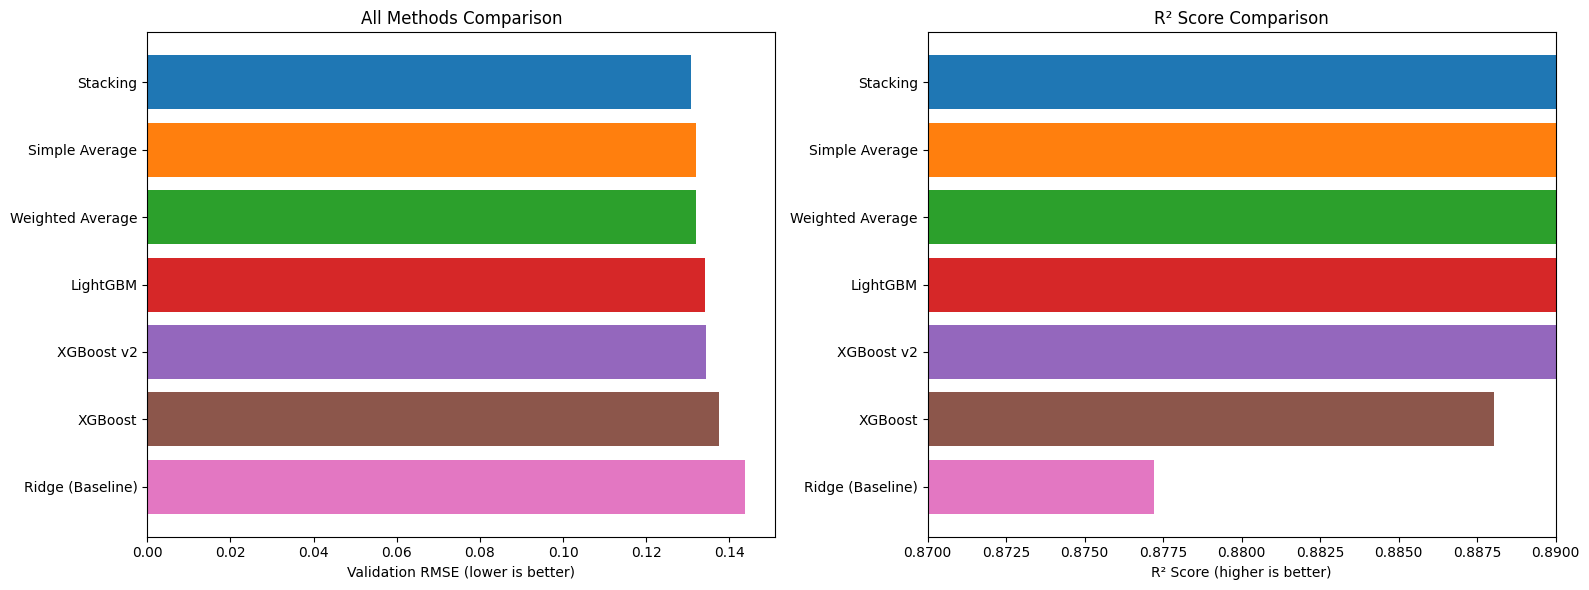


 BEST MODEL: Stacking
   RMSE: 0.1308
   R²:   0.8985


In [7]:
# Compare all Ensemble-Methods
results = pd.DataFrame({
    'Method': [
        'Ridge (Baseline)',
        'XGBoost',
        'LightGBM',
        'XGBoost v2',
        'Simple Average',
        'Weighted Average',
        'Stacking'
    ],
    'Validation RMSE': [
        rmse_ridge,
        rmse_xgb,
        rmse_lgb,
        rmse_xgb2,
        rmse_ensemble_avg,
        rmse_ensemble_weighted,
        rmse_ensemble_stack
    ],
    'R² Score': [
        r2_score(y_val, y_val_pred_ridge),
        r2_score(y_val, y_val_pred_xgb),
        r2_score(y_val, y_val_pred_lgb),
        r2_score(y_val, y_val_pred_xgb2),
        r2_ensemble_avg,
        r2_ensemble_weighted,
        r2_ensemble_stack
    ]
}).sort_values('Validation RMSE')

print("\n" + "=" * 80)
print("FULL ENSEMBLE COMPARISON")
print("=" * 80)
print(results.to_string(index=False))
print("=" * 80)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
axes[0].barh(results['Method'], results['Validation RMSE'], color=colors)
axes[0].set_xlabel('Validation RMSE (lower is better)')
axes[0].set_title('All Methods Comparison')
axes[0].invert_yaxis()

# R²
axes[1].barh(results['Method'], results['R² Score'], color=colors)
axes[1].set_xlabel('R² Score (higher is better)')
axes[1].set_title('R² Score Comparison')
axes[1].set_xlim([0.87, 0.89])
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Highlight best method
best = results.iloc[0]
print(f"\n BEST MODEL: {best['Method']}")
print(f"   RMSE: {best['Validation RMSE']:.4f}")
print(f"   R²:   {best['R² Score']:.4f}")